In [12]:
from scipy.integrate import odeint 
import time
import math
import numpy as np
import pylab as py
from math import *
import numpy as np
from scipy.optimize import newton
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from IPython.display import HTML

In [13]:
m1 = 2                 # mass of pendulum 1 (in kg)
m2 = 1                 # mass of pendulum 2 (in kg)
L1 = 1.4                 # length of pendulum 1 (in meter)
L2 = 1                 # length of pendulum 2 (in meter)
g = 9.8                # gravitatioanl acceleration constant (m/s^2)

In [14]:
#u0 = [-np.pi/10.2, 0, np.pi/5.8, 0]    # initial conditions. 
# u[0] = angle of the first pendulum
# u[1] = angular velocity of the first pendulum
# u[2] = angle of the second pendulum
# u[3] = angular velocity of the second pendulum

In [15]:
tfinal = 25.0       # Final time. Simulation time = 0 to tfinal.
Nt = 751
t = np.linspace(0, tfinal, Nt)

configuration vector $V ~=~ [\theta_1, u_1, \theta_2, u_2 ]$ has two angles $\theta_1$ and $\theta_2$ and the angular velocity $u_1$ and $u_2$ so
$$
 u_1 = \frac{d \theta_1}{dt} ~~~ and ~~~~  u_2 = \frac{d \theta_2}{dt}
$$

we let $c=cos(\theta_1 - \theta_2 )$ and $s = sin(\theta_1 - \theta_2 )$ so the equations are
$$
\frac{d u_1}{dt} ~=~ \frac{m_2  g sin(\theta_2)c - m_2 s ( L_1c u_1^2 + L_2 u_2^2 )- (m_1+m_2)g sin(\theta_1)}{ L_1 (m_1+m_2s^2)}
$$
$$
\frac{d u_2}{dt} ~=~ \frac{(m_1+m_2)(L_1u_1^2s - gsin(u_2) + gsin(u_1)c) + m_2L_2u_2^2sc)}{L_2 (m_1+m_2s^2)}
$$

In [16]:
# Differential equations describing the system
def double_pendulum(u,t,m1,m2,L1,L2,g):
    # du = derivatives
    # u = variables
    # p = parameters
    # t = time variable
    
    du = np.zeros(4)
    c = np.cos(u[0]-u[2])  # intermediate variables
    s = np.sin(u[0]-u[2])  # intermediate variables

    du[0] = u[1]   # d(theta 1)
    du[1] = ( m2*g*np.sin(u[2])*c - m2*s*(L1*c*u[1]**2 + L2*u[3]**2) - (m1+m2)*g*np.sin(u[0]) ) /( L1 *(m1+m2*s**2) )
    du[2] = u[3]   # d(theta 2)   
    du[3] = ((m1+m2)*(L1*u[1]**2*s - g*np.sin(u[2]) + g*np.sin(u[0])*c) + m2*L2*u[3]**2*s*c) / (L2 * (m1 + m2*s**2))
    
    return du


In [17]:
def makepath(theta1, theta2):
    u0 = [np.pi*theta1/180, 0, np.pi*theta2/180, 0]
    tfinal = 25.0       # Final time. Simulation time = 0 to tfinal.
    Nt = 751
    t = np.linspace(0, tfinal, Nt)
    sol = odeint(double_pendulum, u0, t, args=(m1,m2,L1,L2,g))
    return sol

We will take to solutions.  the first is from the stable region and the second is chaotic

In [18]:
sol = makepath(-20., 35.)
sol2 = makepath(-50, 140)

In [19]:
#the functions below are used to create the training set
train_window = 10

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def preprocess_sol(sol, train_window):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized = scaler.fit_transform(sol.reshape(-1, 4))
    train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
    train_inout_seq= create_inout_sequences(train_data_normalized.reshape(751, 4), train_window)
    return train_inout_seq


In [20]:
train_inout_seq = preprocess_sol(sol, train_window)
len(train_inout_seq)

741

In [21]:
class MyLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(4, 100)
        self.linear = nn.Linear(100, 4)
        self.c_h = (torch.zeros(1,1,100),
                    torch.zeros(1,1,100))
    def forward(self, x):
        h, self.c_h= self.lstm(x.view(len(x) ,1, -1), self.c_h)
        predictions = self.linear(h.view(len(x), -1))
        return predictions[-1]

In [22]:
use_saved_model = False

if use_saved_model:
    model = MyLSTM()
    model.load_state_dict(torch.load('lstm-pend2'))  #this model is in the stable region
    #model.load_state_dict(torch.load('lstm-pend3'))  #this model is from chaotic region                  
else:
    torch.save(model.state_dict(), 'lstm-pend3')

In [23]:
if use_saved_model == False:
    #model = MyLSTM()
    loss_function = nn.MSELoss()
    hidden_layer_size = 100
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    epochs =2002 #52

    for i in range(epochs):
        seq_err = 0.0
        for _ in range(500):
            num = np.random.randint(len(train_inout_seq))
            seq = train_inout_seq[num][0]
            labels = train_inout_seq[num][1]
            optimizer.zero_grad()
            model.c_h = (torch.zeros(1, 1, hidden_layer_size),
                            torch.zeros(1, 1, hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred.reshape(1,4), labels)
            single_loss.backward()
            optimizer.step()
            seq_err+= single_loss.item()
        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
            print(f'seq: {i:3} loss: {seq_err:10.8f}')
        if seq_err < 0.000007:
            break

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    torch.save(model.state_dict(), 'lstm-pend3')

epoch:   1 loss: 0.00434506
seq:   1 loss: 4.26600338
epoch:  26 loss: 0.00010257
seq:  26 loss: 0.10513923
epoch:  51 loss: 0.00012359
seq:  51 loss: 0.03987590
epoch:  76 loss: 0.00002715
seq:  76 loss: 0.02564775
epoch: 101 loss: 0.00007665
seq: 101 loss: 0.03325882
epoch: 126 loss: 0.00028434
seq: 126 loss: 0.02205222
epoch: 151 loss: 0.00000839
seq: 151 loss: 0.00425007
epoch: 176 loss: 0.00000076
seq: 176 loss: 0.02464662
epoch: 201 loss: 0.00009528
seq: 201 loss: 0.00695440
epoch: 226 loss: 0.00000890
seq: 226 loss: 0.00339839
epoch: 251 loss: 0.00002270
seq: 251 loss: 0.01272163
epoch: 276 loss: 0.00030609
seq: 276 loss: 0.01102755
epoch: 301 loss: 0.00001191
seq: 301 loss: 0.00552463
epoch: 326 loss: 0.00003239
seq: 326 loss: 0.00486821
epoch: 351 loss: 0.00000126
seq: 351 loss: 0.00782920
epoch: 376 loss: 0.00000018
seq: 376 loss: 0.00687697
epoch: 401 loss: 0.00000040
seq: 401 loss: 0.00512127
epoch: 426 loss: 0.00000025
seq: 426 loss: 0.00126693
epoch: 451 loss: 0.00000049


In [24]:
#this is the full OneStep function.   it 
def OneStep(data, steps = 100):
    print('data set length =', len(data))
    train_window = 10
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized = scaler.fit_transform(data.reshape(-1, 4))
    fut_pred = len(data) -train_window
    test_inputs = train_data_normalized[0:train_window].reshape(train_window,4).tolist()
    #print(test_inputs)
    s2 = train_data_normalized.reshape(len(data),4).tolist()
    realdata = data
    model.eval()
    preds = test_inputs.copy()
    t2 = test_inputs
    hidden_layer_size = 100
    x = 0
    for i in range(fut_pred):
        seq = torch.FloatTensor(t2[i:])
        model.c_h = (torch.zeros(1, 1, hidden_layer_size),
                        torch.zeros(1, 1, hidden_layer_size))
        x = model(seq)
        preds.append(x.detach().numpy())
        t2.append(x.detach().numpy())
    actual_predictions = scaler.inverse_transform(np.array(preds ).reshape(-1,4))
    print(len(actual_predictions))
    
    # the following will plot the lower mass path for steps using the actual ODE sover
    # and the predicitons
    plt.figure( figsize=(10,5))
    u0 = data[:,0]     # theta_1 
    u1 = data[:,1]     # omega 1
    u2 = data[:,2]     # theta_2 
    u3 = data[:,3]     # omega_2 
    up0 = actual_predictions[:,0]     # theta_1 
    up1 = actual_predictions[:,1]     # omega 1
    up2 = actual_predictions[:,2]     # theta_2 
    up3 = actual_predictions[:,3]     # omega_2 
    x1 = L1*np.sin(u0);          # First Pendulum
    y1 = -L1*np.cos(u0);
    x2 = x1 + L2*np.sin(u2);     # Second Pendulum
    y2 = y1 - L2*np.cos(u2);
    xp1 = L1*np.sin(up0);          # First Pendulum
    yp1 = -L1*np.cos(up0);
    xp2 = xp1 + L2*np.sin(up2);     # Second Pendulum
    yp2 = yp1 - L2*np.cos(up2);
    print(x2[0], y2[0])
    plt.plot(x2[0:steps], y2[0:steps], color='r')
    plt.plot(xp2[0:steps],yp2[0:steps] , color='g')
    err = 0.0
    errs = 0.0
    cnt = 0
    badday  =0.0
    errsq = 0.0
    maxerr = 0.0
    maxloc = 0
    
    #the following attempts to make an estimate of the error.  not very good.
    for i in range(len(actual_predictions)):
        er =np.linalg.norm(realdata[i]-actual_predictions[i])
        err += er
        if er > maxerr:
            maxerr = er
            maxloc = i
    print("mean error =", err/101)
    print('maxerr =', maxerr, ' at ', maxloc)
    return actual_predictions

data set length = 751


C:\Users\jagpr\AppData\Local\Temp\ipykernel_42976\3029345326.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  seq = torch.FloatTensor(t2[i:])


751
0.09474823569510987 -2.1347217133892635
mean error = 20.15520590623926
maxerr = 6.99262780949939  at  380


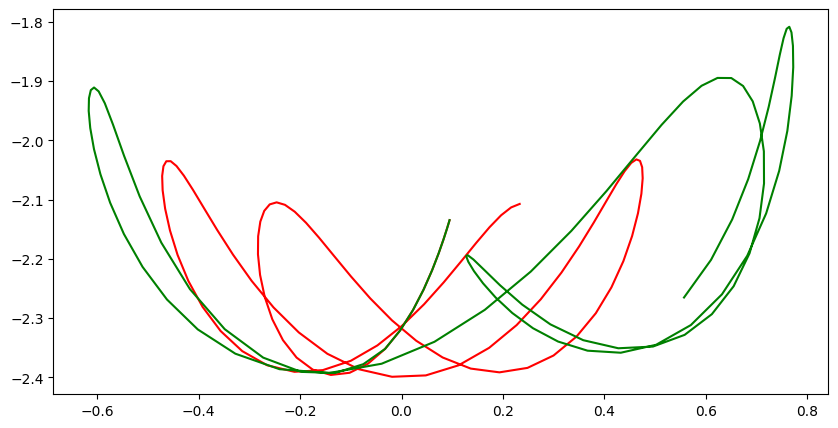

In [25]:
actual_predictions =OneStep(sol, steps=100)

data set length = 751
751
-0.42967461068002977 -0.13385821044217716
mean error = 101.17403066744971
maxerr = 30.008975633374515  at  42


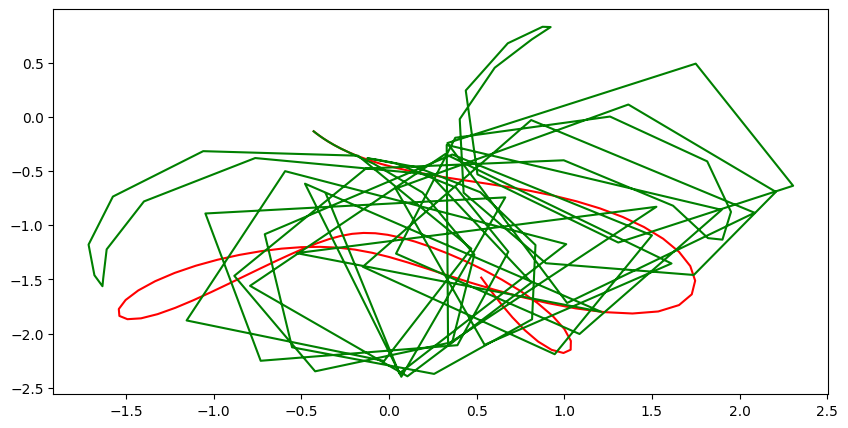

In [26]:
#now do the same for the chaotic solution
actual_predictions2 =OneStep(sol2, steps=100)

In [27]:
def make_anim(data2):
    def init2():
        line21.set_data([], [])
        line22.set_data([], [])
        line23.set_data([], [])
        line24.set_data([], [])
        line25.set_data([], [])
        time_string.set_text('')
        return  line23,line24, line25, line21, line22, time_string

    def animate2(i):
        # Motion trail sizes. Defined in terms of indices. Length will vary with the time step, dt. E.g. 5 indices will span a lower distance if the time step is reduced.
        trail1 = 6              # length of motion trail of weight 1 
        trail2 = 8              # length of motion trail of weight 2

        dt = t[2]-t[1]          # time step

        line21.set_data(xp1[i:max(1,i-trail1):-1], yp1[i:max(1,i-trail1):-1])   # marker + line of first weight
        line22.set_data(xp2[i:max(1,i-trail2):-1], yp2[i:max(1,i-trail2):-1])   # marker + line of the second weight

        line23.set_data([xp1[i], xp2[i]], [yp1[i], yp2[i]])       # line connecting weight 2 to weight 1
        line24.set_data([xp1[i], 0], [yp1[i],0])                # line connecting origin to weight 1

        line25.set_data([0, 0], [0, 0])
        time_string.set_text(time_template % (i*dt))
        return  line23, line24,line25,line21, line22, time_string

    fig2 = plt.figure()
    ax2 = plt.axes(xlim=(-L1-L2-0.5, L1+L2+0.5), ylim=(-2.5, 1.5))
    #line, = ax.plot([], [], lw=2,,markersize = 9, markerfacecolor = "#FDB813",markeredgecolor ="#FD7813")
    line21, = ax2.plot([], [], 'o-',color = '#d2eeff',markersize = 12, markerfacecolor = '#0077BE',lw=2, markevery=10000, markeredgecolor = 'k')   # line for Earth
    line22, = ax2.plot([], [], 'o-',color = '#ffebd8',markersize = 12, markerfacecolor = '#f66338',lw=2, markevery=10000, markeredgecolor = 'k')   # line for Jupiter
    line23, = ax2.plot([], [], color='k', linestyle='-', linewidth=2)
    line24, = ax2.plot([], [], color='k', linestyle='-', linewidth=2)
    line25, = ax2.plot([], [], 'o', color='k', markersize = 10)
    time_template = 'Time = %.1f s'
    time_string = ax2.text(0.05, 0.9, '', transform=ax2.transAxes)
    ax2.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
    ax2.get_yaxis().set_ticks([])    # enable this to hide y axis ticks

    u0 = data2[:,0]     # theta_1 
    u1 = data2[:,1]     # omega 1
    u2 = data2[:,2]     # theta_2 
    u3 = data2[:,3]     # omega_2 
    xp1 = L1*np.sin(u0);          # First Pendulum
    yp1 = -L1*np.cos(u0);

    xp2 = xp1 + L2*np.sin(u2);     # Second Pendulum
    yp2 = yp1 - L2*np.cos(u2);

    anim2 = animation.FuncAnimation(fig2, animate2, init_func=init2,
                                   frames=Nt, interval=1000*(t[2]-t[1])*0.8, blit=True)
    return anim2

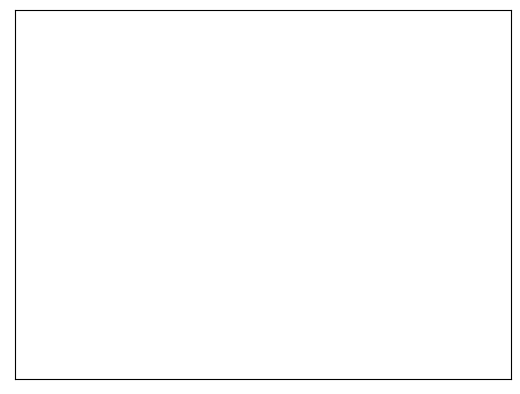

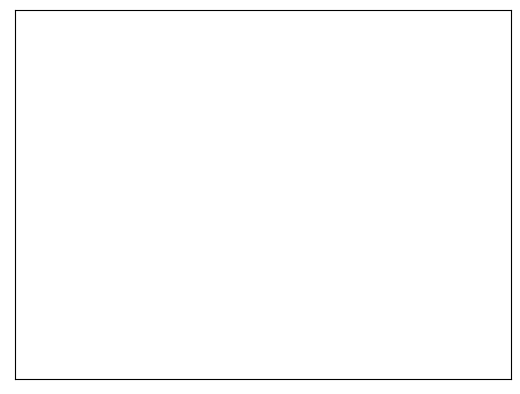

In [28]:
data = sol
data2 = actual_predictions
anim = make_anim(data)
anim2 = make_anim(data2)

In [29]:
# HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [ ]:
HTML(anim2.to_html5_video())

In [ ]:
#use the following to save these to gif files
#anim2.save('double_pendulum_animation2-5-2.5-training.gif', fps=1.0/(t[2]-t[1]), writer = 'imagemagick')
#anim.save('double_pendulum_animation-5-2.5-training.gif', fps=1.0/(t[2]-t[1]), writer = 'imagemagick')


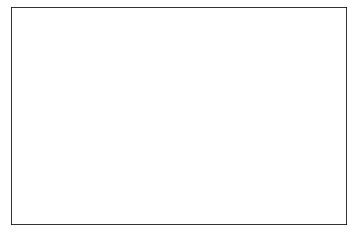

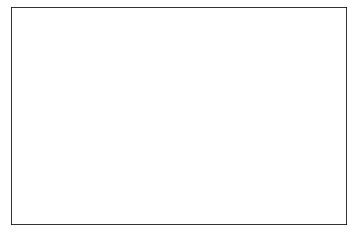

In [ ]:
#now do the chaotic case
data = sol2
data2 = actual_predictions2
anim = make_anim(data)
anim2 = make_anim(data2)

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
HTML(anim2.to_html5_video())